## 한글 폰트 설치
https://teddylee777.github.io/colab/colab-korean/


In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter    # 배열에서 각 원소 몇번 나오는지 알려줌
import ast
from matplotlib import rc 

# truncation 없이 출력
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')

<ipython-input-3-0c79f28ff0d4>:10: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## csv 파일 관리

In [4]:
df = pd.read_csv("total_tokenized_mecab.csv")

<ipython-input-4-c52785eaf9fc>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("total_tokenized_mecab.csv")


## mecab 토큰화 형태 수정 
- 품사 태깅 (문자열, 문자열) 형태 -> (문자열, 품사 태깅) 형태로 변환 (eval)

In [5]:
for i in range(len(df['mecab'])):
  df['mecab'].loc[i] = eval(df['mecab'].loc[i])

<ipython-input-5-642702a6bb42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mecab'].loc[i] = eval(df['mecab'].loc[i])


## Word2Vec

### 명사, 외국어 토큰 추출

In [ ]:
#NNP, SL, NNG 일반, 고유, 외국어

In [6]:
total = []
for idx in range(len(df['mecab'])):
  word = []
  for i, j in df['mecab'].loc[idx]:
    if j == "NNP" or j == "SL" or j == "NNG":
      word.append(i)
  total.append(word)

In [7]:
df = df.assign(word = total)

In [8]:
corpus = []
for i in df['word']:
  corpus.append(i)

In [9]:
corpus_total = []
for i in df['word']:
  for j in i:
    corpus_total.append(j)

In [10]:
from gensim.models import Word2Vec
model = Word2Vec(corpus, vector_size=100, window = 4, min_count = 1, workers = 4, sg = 1)

In [13]:
model_result = model.wv.most_similar('작대기')
print(model_result)

[('아이스', 0.8950097560882568), ('술', 0.7763606905937195), ('빙', 0.774588406085968), ('술파', 0.7628461122512817), ('반작', 0.7572365403175354), ('반응', 0.7490670680999756), ('마약상', 0.7429604530334473), ('술사', 0.7376585602760315), ('김치', 0.7368917465209961), ('캔디', 0.7340601682662964)]


## PCA 주성분 분석

In [11]:
from sklearn.decomposition import PCA

# fit a 2d PCA model to the vectors

vectors = model.wv.vectors
words = list(model.wv.key_to_index.keys())
pca = PCA(n_components=2)
PCA_result = pca.fit_transform(vectors)

# prepare a dataframe
words = pd.DataFrame(words)
PCA_result = pd.DataFrame(PCA_result)
PCA_result['x_values'] =PCA_result.iloc[0:, 0]
PCA_result['y_values'] =PCA_result.iloc[0:, 1]
PCA_final = pd.merge(words, PCA_result, left_index=True, right_index=True)
PCA_final['word'] =PCA_final.iloc[0:, 0]
PCA_data_complet =PCA_final[['word','x_values','y_values']]

In [15]:
print(PCA_data_complet)

             word  x_values  y_values
0     아이스          1.987585 -0.484749
1     작대기          2.032649 -0.473355
2     텔레           1.706195 -0.478378
3     술            1.668864 -0.512682
4     곳            2.140780 -0.629499
...  ..                 ...       ...
6817  passing     -0.209436 -0.043281
6818  examination -0.239650 -0.023754
6819  ypm         -0.251200 -0.278712
6820  devil       -0.232110 -0.117956
6821  킨           -0.357694 -0.770291

[6822 rows x 3 columns]


## Kmeans Clustering

### 최적의 k 값 찾기
- PCA 분석 결과 x_values, y_values 기준

In [12]:
from sklearn.cluster import KMeans

x = []   # k 가 몇개인지 
y = []   # 응집도가 몇인지 

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(PCA_result.iloc[0:,:2])
    
    x.append(k)
    y.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

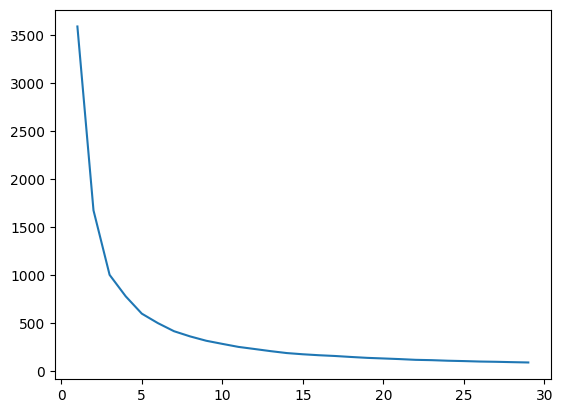

In [13]:
plt.plot(x, y)

In [14]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(PCA_result.iloc[0:,:2])
PCA_data_complet['labels'] = kmeans.predict(PCA_result.iloc[0:,:2])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-14-3efdbcfd8923>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PCA_data_complet['labels'] = kmeans.predict(PCA_result.iloc[0:,:2])


In [15]:
# 단어 빈도 수 열 추가
PCA_data_complet['counts'] = 0

for i, word in enumerate(PCA_data_complet['word']):  
  PCA_data_complet['counts'][i] = corpus_total.count(word)

<ipython-input-15-af7c61563b2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PCA_data_complet['counts'] = 0
<ipython-input-15-af7c61563b2d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PCA_data_complet['counts'][i] = corpus_total.count(word)


In [16]:
PCA_data_complet

word  x_values  y_values  labels  counts
0     아이스          1.972654 -0.508801  1       117785
1     작대기          2.086396 -0.492653  1       72315 
2     텔레           1.708063 -0.505510  1       28410 
3     술            1.652529 -0.524766  1       22453 
4     곳            2.161584 -0.618568  1       21791 
...  ..                 ...       ... ..         ... 
6817  passing     -0.275070 -0.045500  0       1     
6818  examination -0.199953 -0.076130  0       1     
6819  ypm         -0.319766 -0.337552  0       1     
6820  devil       -0.295115 -0.170539  0       1     
6821  킨           -0.358754 -0.780214  0       1     

[6822 rows x 5 columns]

## 마약 군집만 추출해서 2차 클러스터링

In [17]:
PCA_drug = PCA_data_complet[PCA_data_complet['labels']==PCA_data_complet.loc[0].labels]

In [29]:
PCA_drug

word  x_values  y_values  labels  counts
0    아이스   1.987585 -0.484749  1       117785
1    작대기   2.032649 -0.473355  1       72315 
2    텔레    1.706195 -0.478378  1       28410 
3    술     1.668864 -0.512682  1       22453 
4    곳     2.140780 -0.629499  1       21791 
..  ..          ...       ... ..         ... 
695  wang  1.756001 -0.117740  1       30    
720  울드    1.564978 -0.408133  1       29    
742  남포    1.743542 -0.394368  1       27    
816  남사    1.512392 -0.560484  1       23    
841  스빙    1.783407 -0.390714  1       22    

[296 rows x 5 columns]

## 검색 키워드 제외하고 2차 클러스터링

In [18]:
keywords = ['위드','대마초','사티바','인디카','대마','해시시','허브','삥두','사끼','샤부','아이스','작대기','떨','술','크리스탈','필로폰','뽕','버섯',
            '스틸녹스','옥시코돈','졸피뎀','트라마돌','캔디','케타민','코카인','최음제','발정제','엘에스디','엑스터시','도리도리','몰리','텔레','드라퍼','브액',
            '패치']

In [19]:
PCA_drug_removed = PCA_drug
for i in keywords:
  PCA_drug_removed = PCA_drug_removed[~PCA_drug_removed['word'].str.contains(i)]

In [20]:
PCA_drug_removed

word  x_values  y_values  labels  counts
4    곳     2.161584 -0.618568  1       21791 
5    팝     1.943238 -0.552386  1       19460 
7    액     2.384048 -0.711672  1       17301 
10   샘플    2.181585 -0.200920  1       14424 
11   브     2.269383 -0.641958  1       14104 
..  ..          ...       ... ..         ... 
695  wang  1.678221 -0.177632  1       30    
720  울드    1.544974 -0.394789  1       29    
742  남포    1.667072 -0.387837  1       27    
816  남사    1.454738 -0.563386  1       23    
841  스빙    1.761886 -0.368338  1       22    

[266 rows x 5 columns]

## Matplotlib 시각화

### 버전1: 전체 단어 & 전체 텍스트

Streaming output truncated to the last 5000 lines.


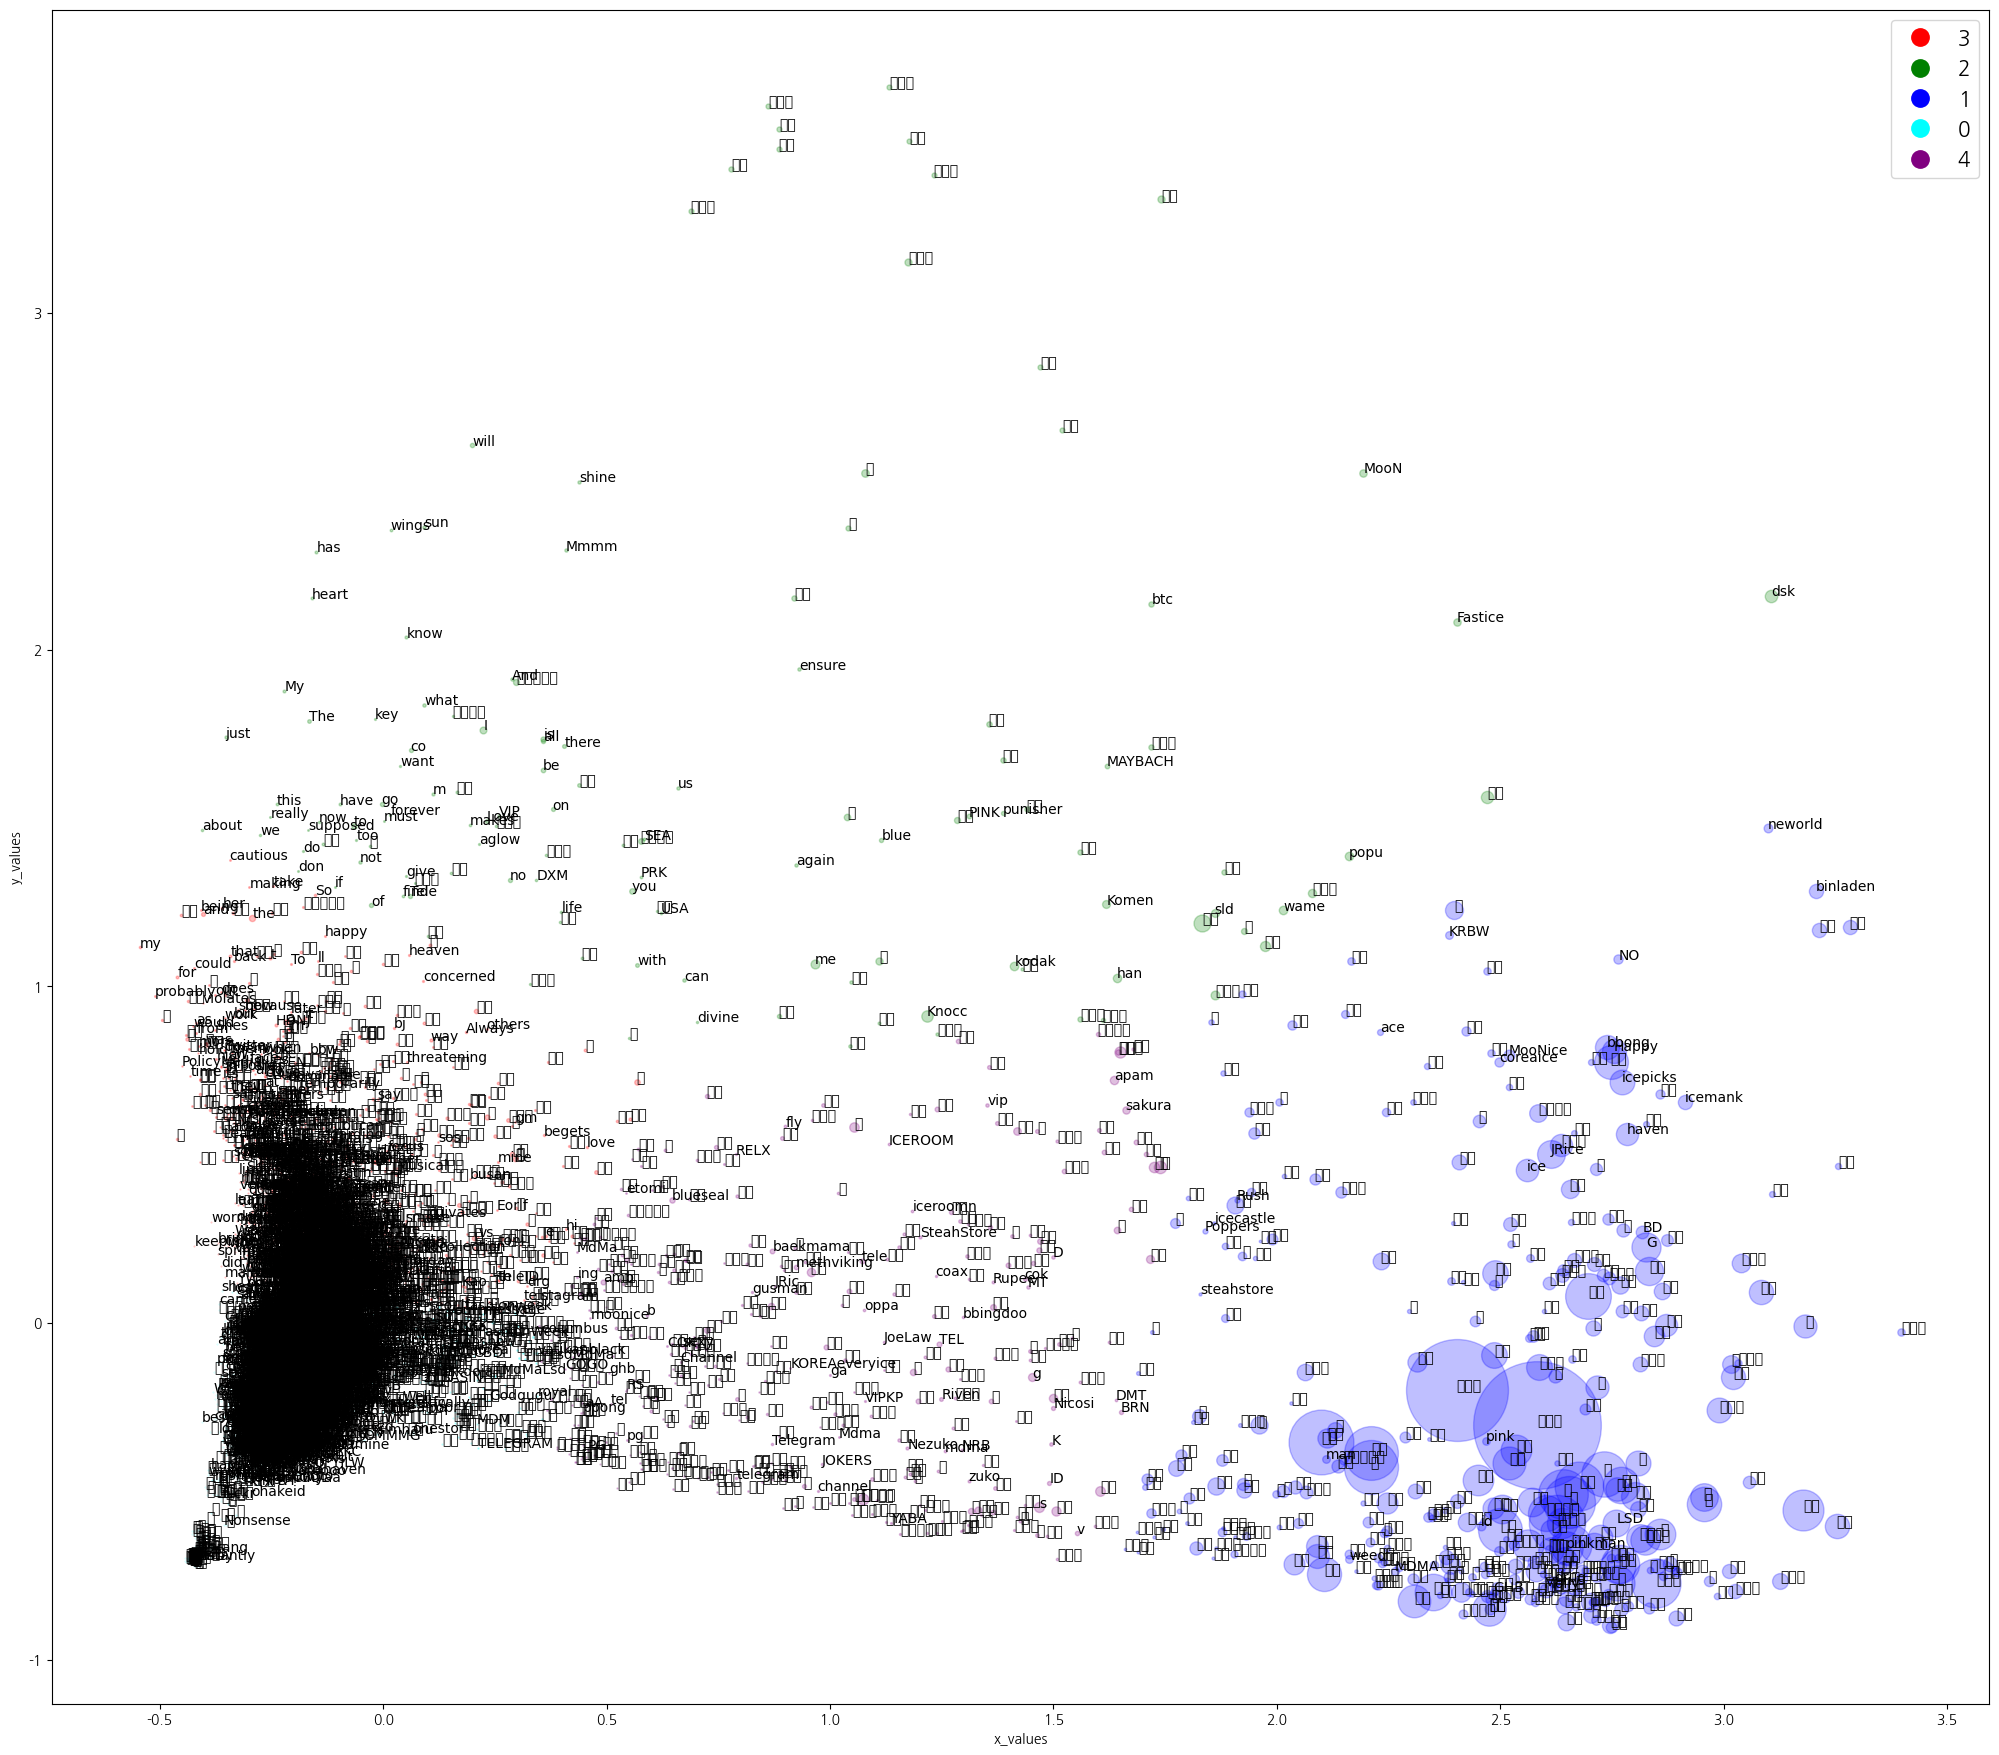

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_data_complet.labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_data_complet.iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_data_complet.x_values[i], PCA_data_complet.y_values[i], s=PCA_data_complet.counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

#[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet.iterrows() if row.labels == PCA_data_complet.labels[0]]
[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet.iterrows()]
plt.show()

### 버전2: 전체 단어 & 마약 군집 텍스트만

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_data_complet.labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_data_complet.iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_data_complet.x_values[i], PCA_data_complet.y_values[i], s=PCA_data_complet.counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet.iterrows() if row.labels == PCA_data_complet.labels[0]]
plt.show()

### 버전3: 일부 단어

In [ ]:
PCA_data_complet[PCA_data_complet['counts'] >= 5]

word  x_values  y_values  labels  counts
0     아이스     1.964385 -0.481631  0       117785
1     작대기     2.006160 -0.424773  0       72315 
2     텔레      1.779510 -0.487532  0       28410 
3     술       1.636975 -0.507069  0       22453 
4     곳       2.139642 -0.586511  0       21791 
...  ..            ...       ... ..         ... 
1932  Having -0.372639  0.714346  2       5     
1933  house  -0.266203  0.587878  3       5     
1934  강릉     -0.139435  0.105285  3       5     
1935  B      -0.259767  0.301525  3       5     
1936  사하      0.038176  0.252928  3       5     

[1937 rows x 5 columns]

In [ ]:
PCA_data_complet[PCA_data_complet['counts'] >= 5]['labels'].value_counts() 

3    811
4    386
2    370
0    300
1    70 
Name: labels, dtype: int64

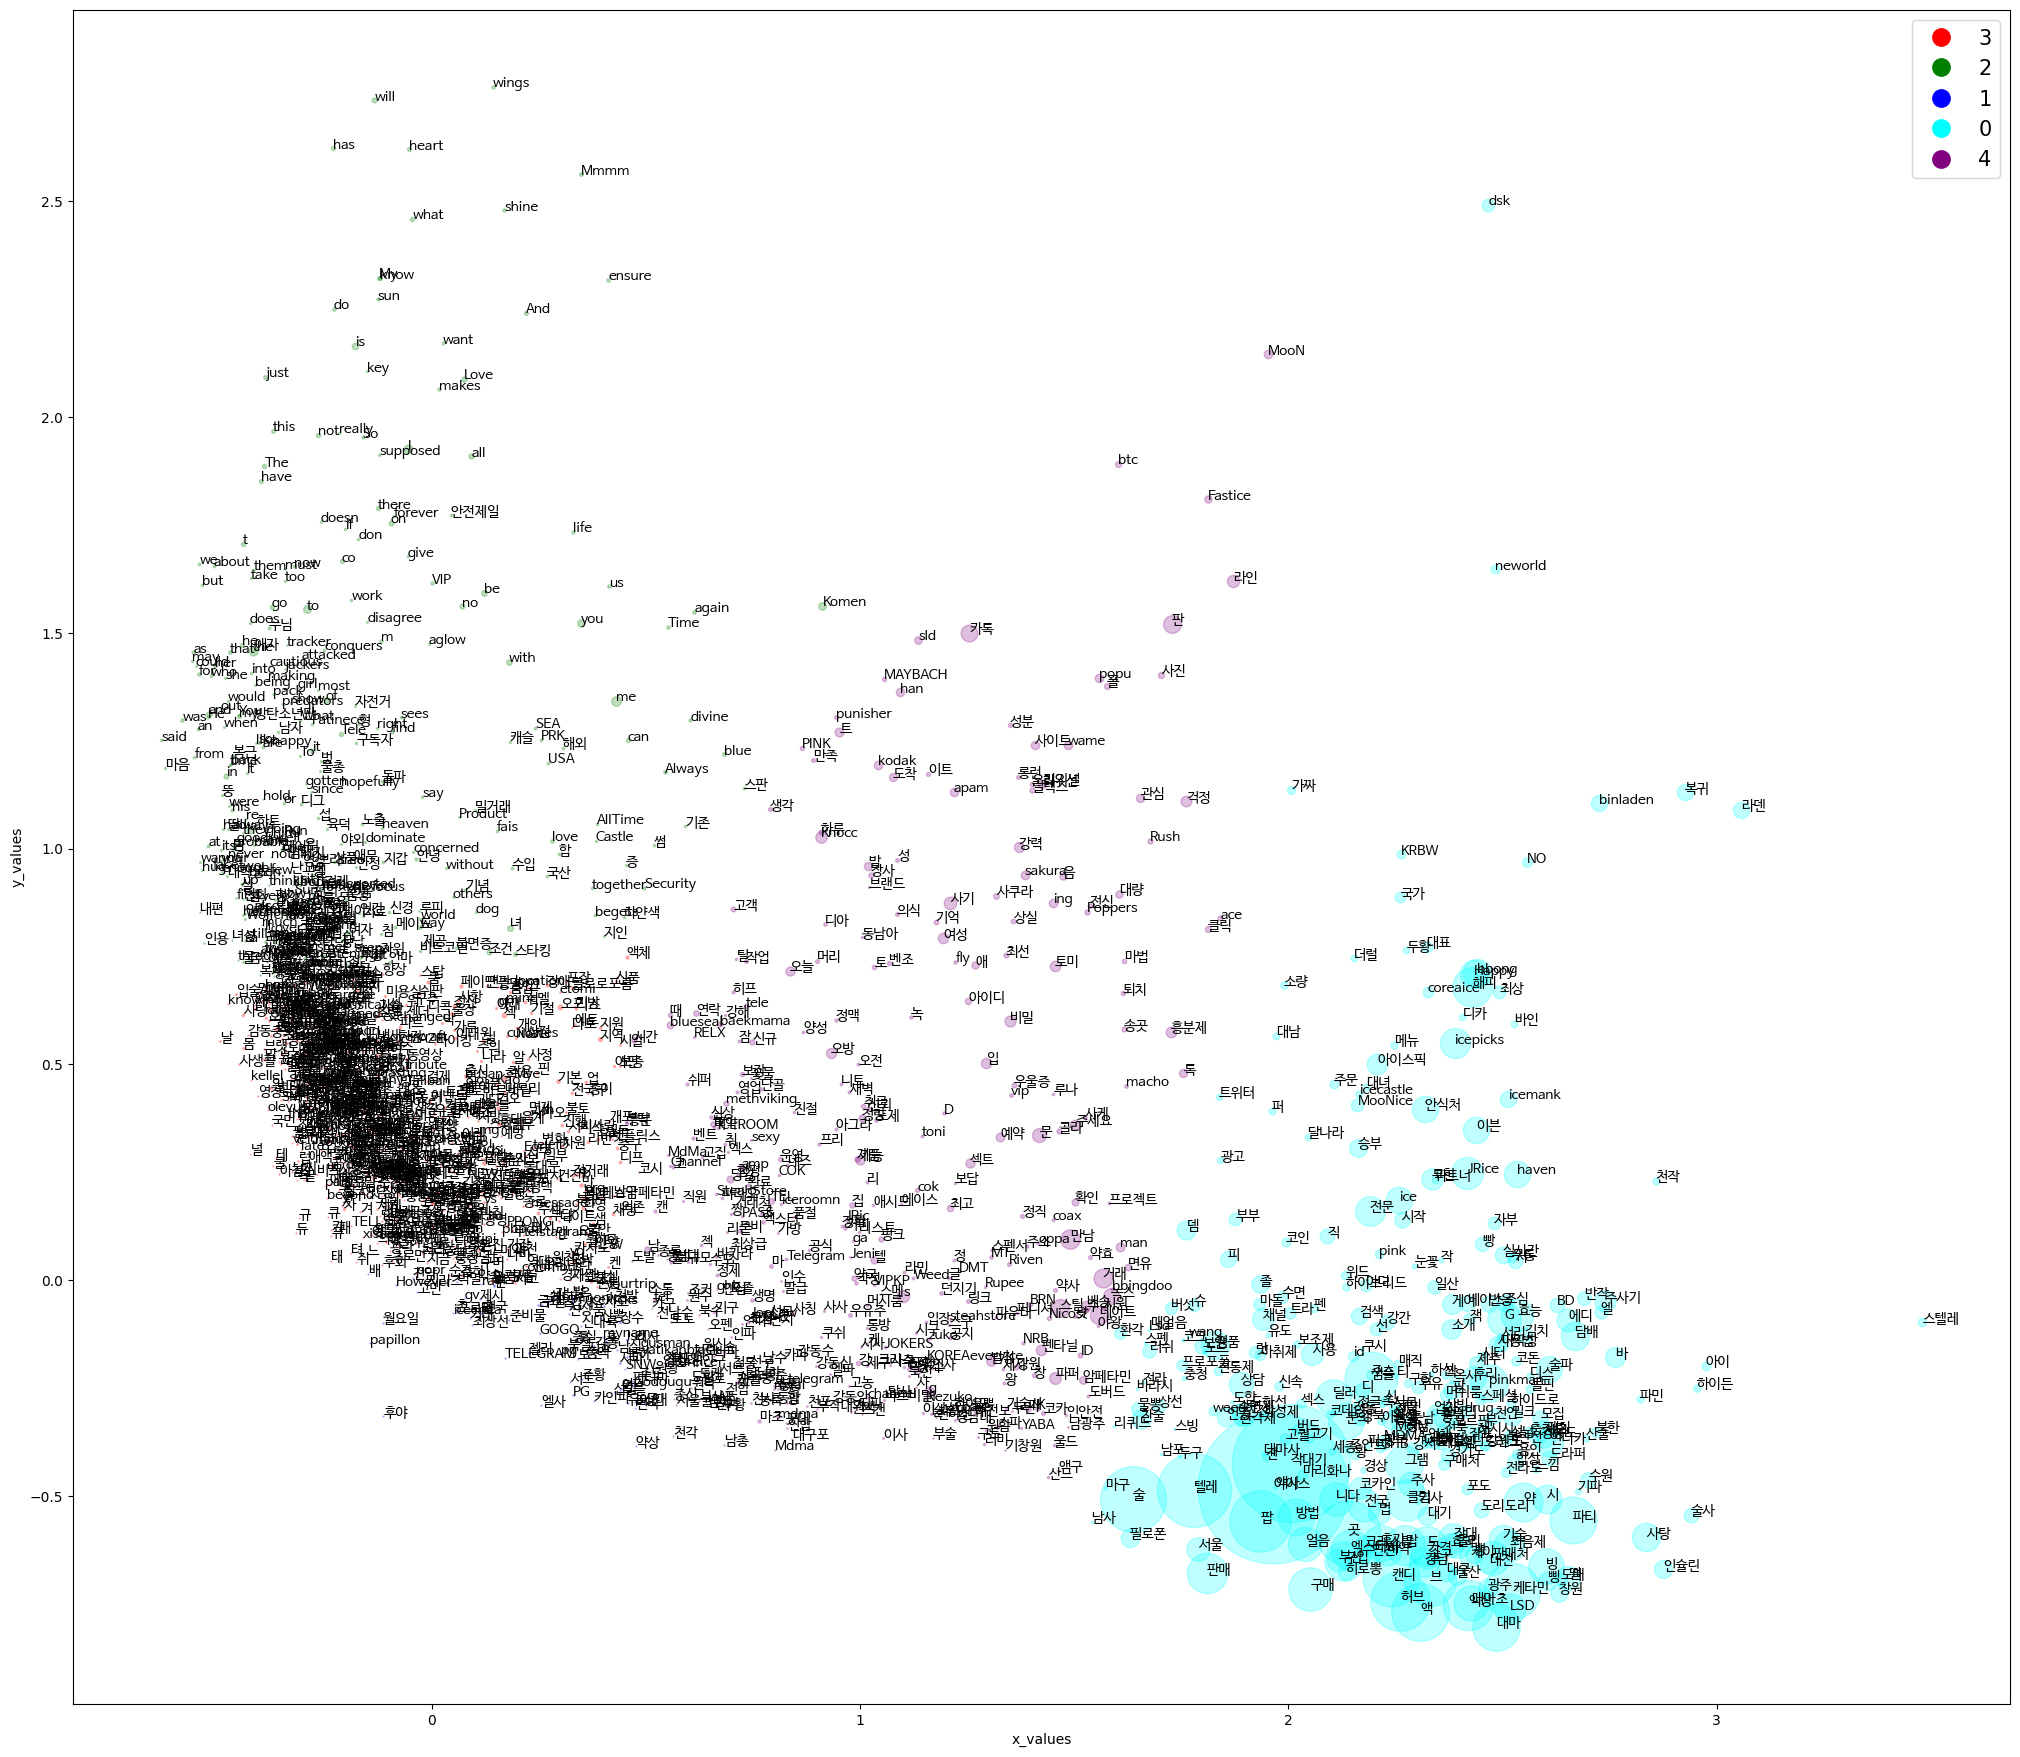

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_data_complet[PCA_data_complet['counts'] >= 5].labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_data_complet[PCA_data_complet['counts'] >= 5].iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_data_complet[PCA_data_complet['counts'] >= 5].x_values[i], PCA_data_complet[PCA_data_complet['counts'] >= 5].y_values[i], s=PCA_data_complet[PCA_data_complet['counts'] >= 5].counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet[PCA_data_complet['counts'] >= 5].iterrows()]
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


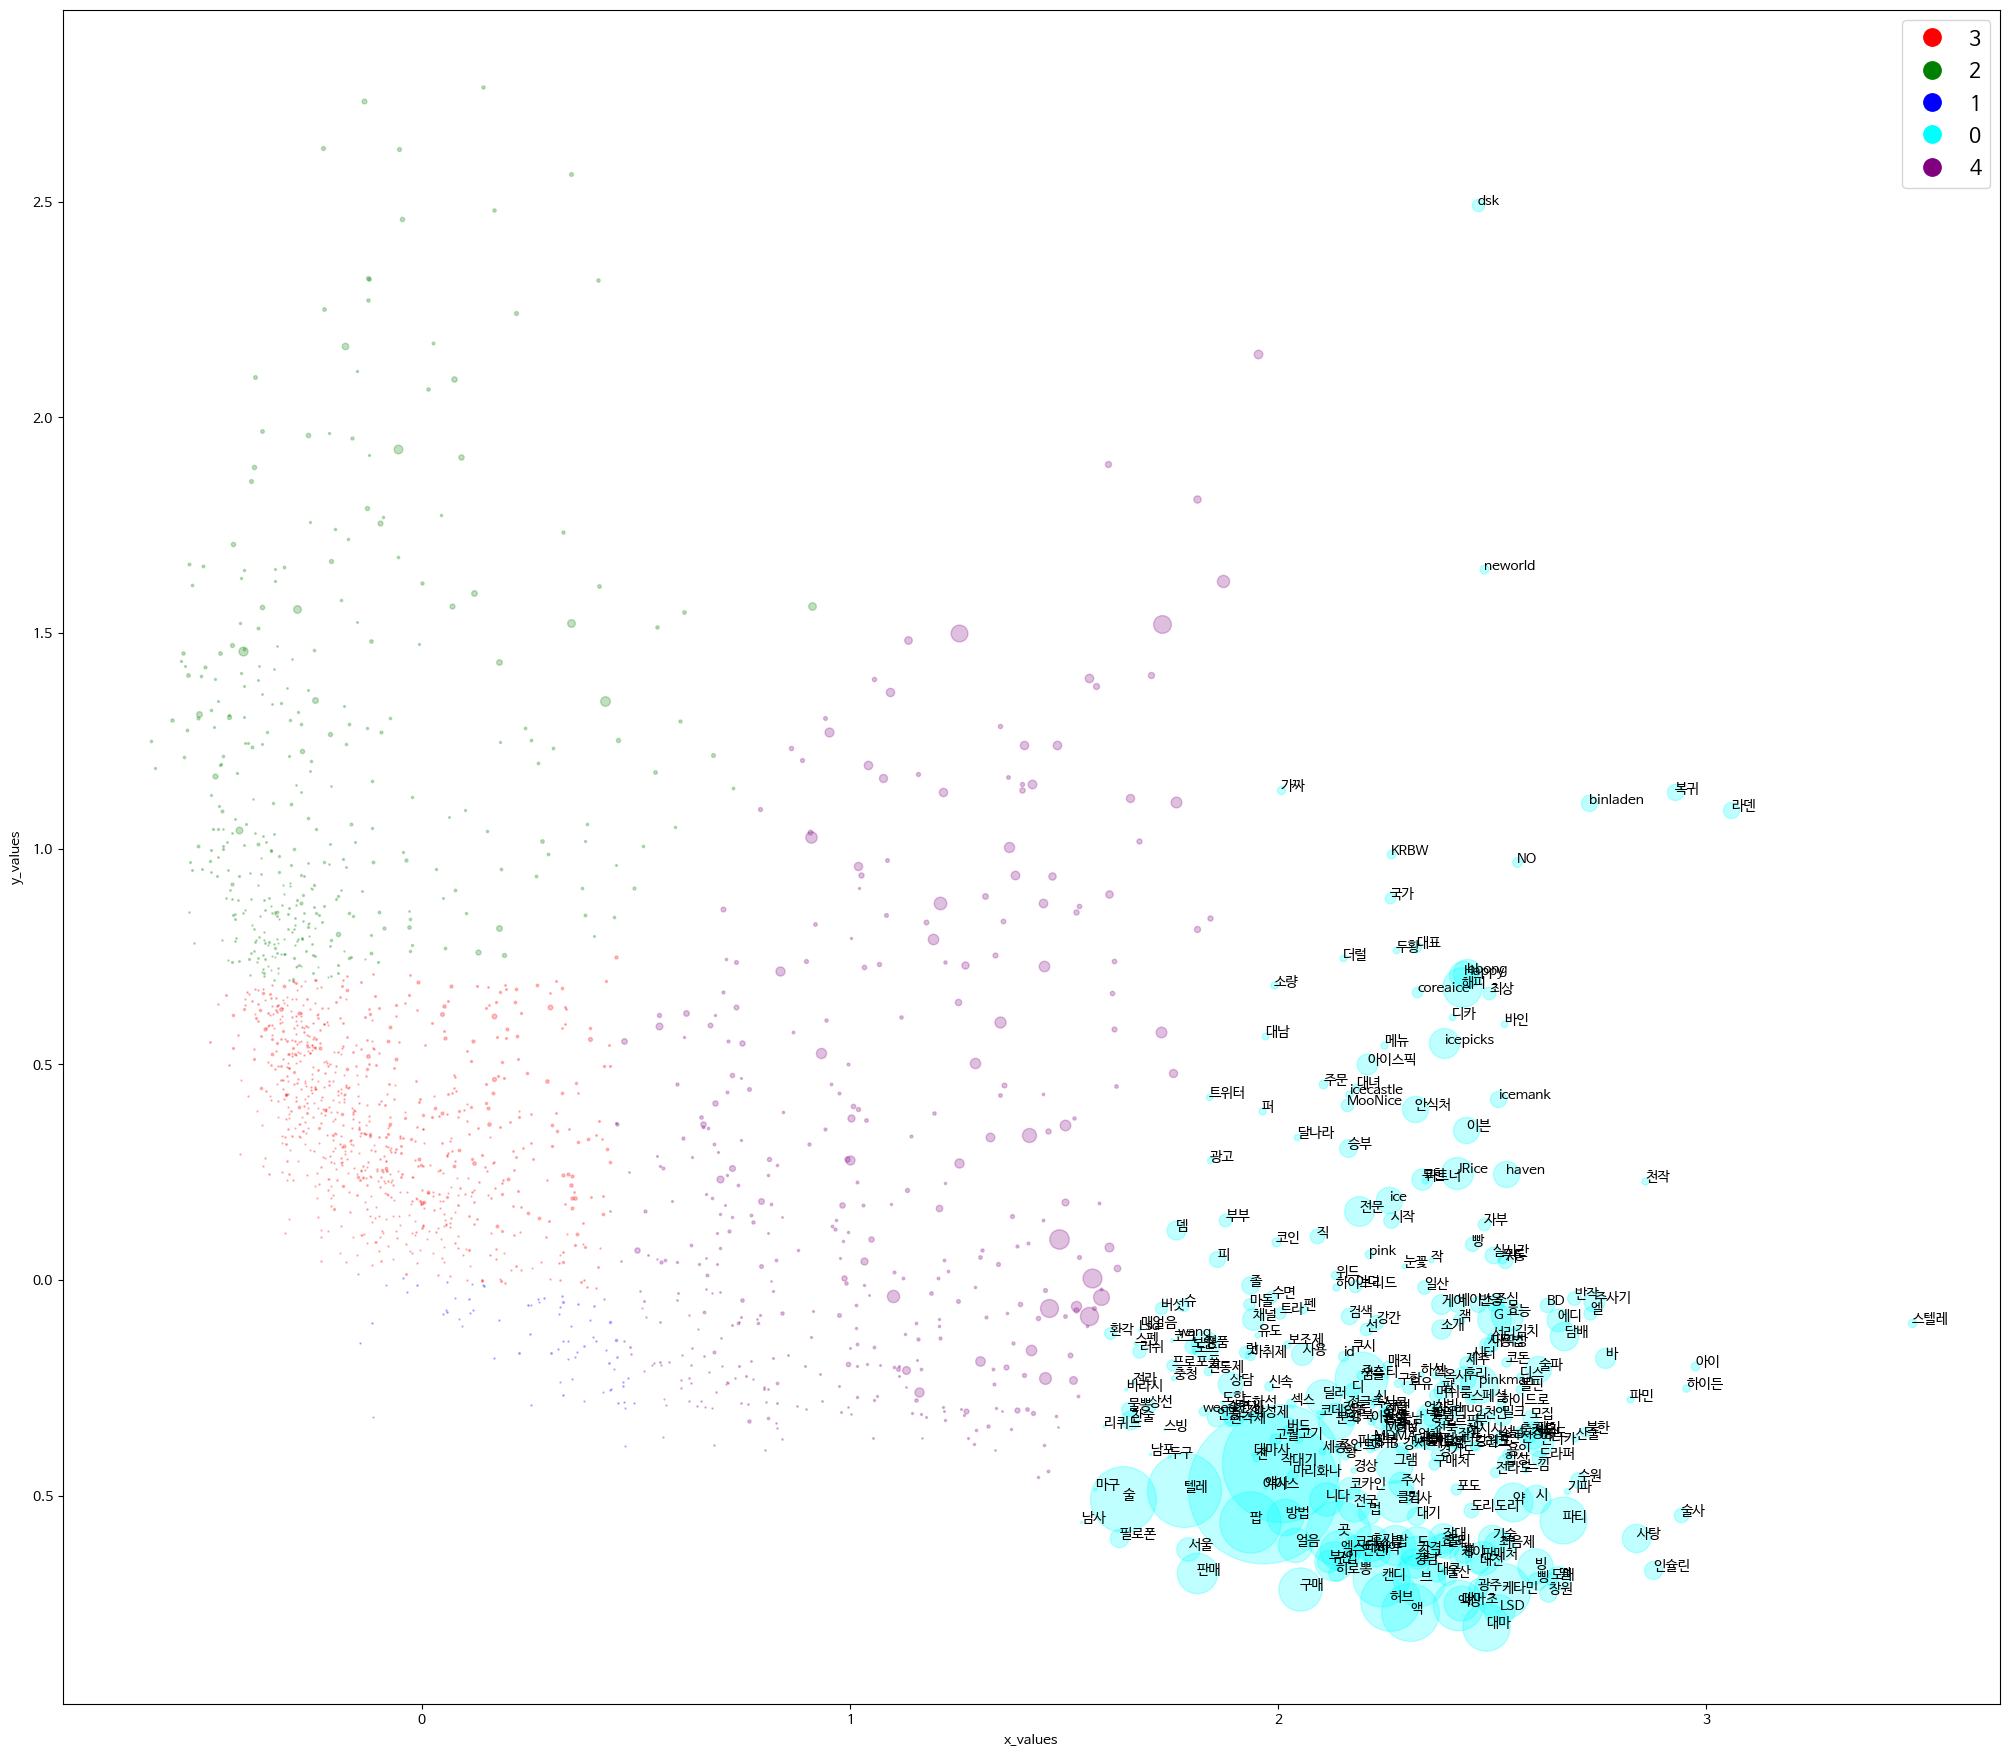

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_data_complet[PCA_data_complet['counts'] >= 5].labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_data_complet[PCA_data_complet['counts'] >= 5].iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_data_complet[PCA_data_complet['counts'] >= 5].x_values[i], PCA_data_complet[PCA_data_complet['counts'] >= 2].y_values[i], s=PCA_data_complet[PCA_data_complet['counts'] >= 5].counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet[PCA_data_complet['counts'] >= 5].iterrows() if row.labels == PCA_data_complet[PCA_data_complet['counts'] >= 5].labels[0]]
plt.show()

### 버전4: 마약 군집만

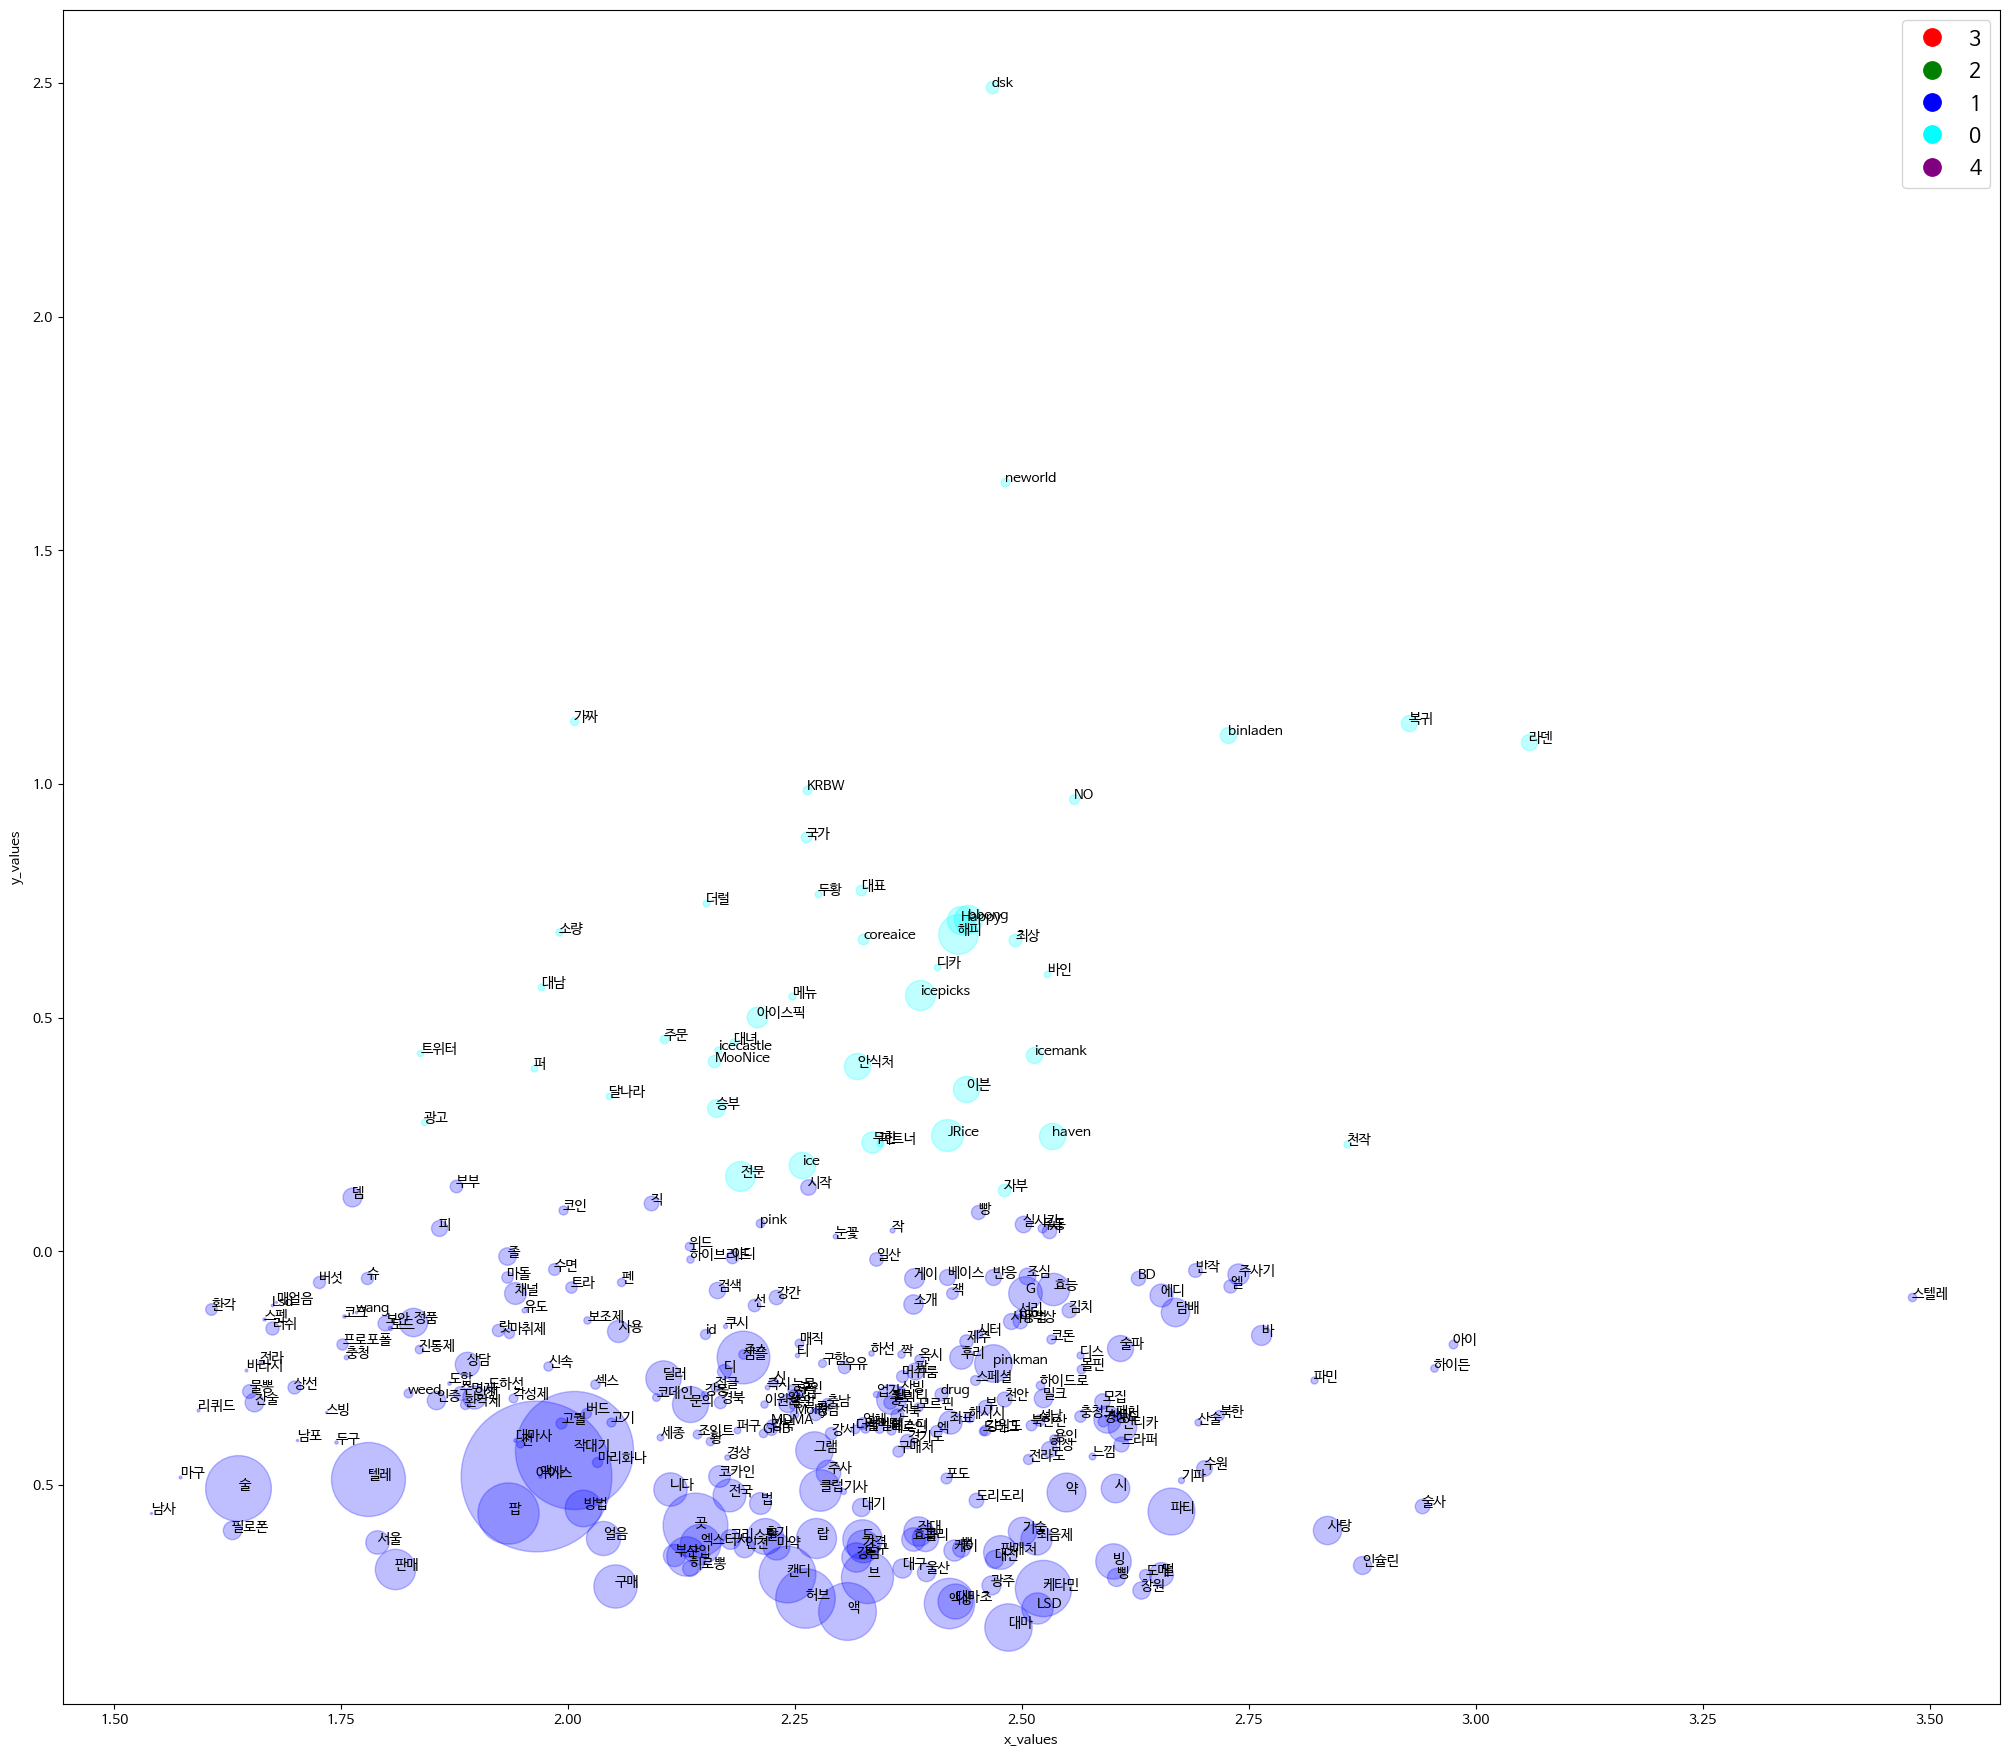

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_drug.labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_drug.iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_drug.x_values[i], PCA_drug.y_values[i], s=PCA_drug.counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

#[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet.iterrows() if row.labels == PCA_data_complet.labels[0]]
[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_drug.iterrows()]
plt.show()

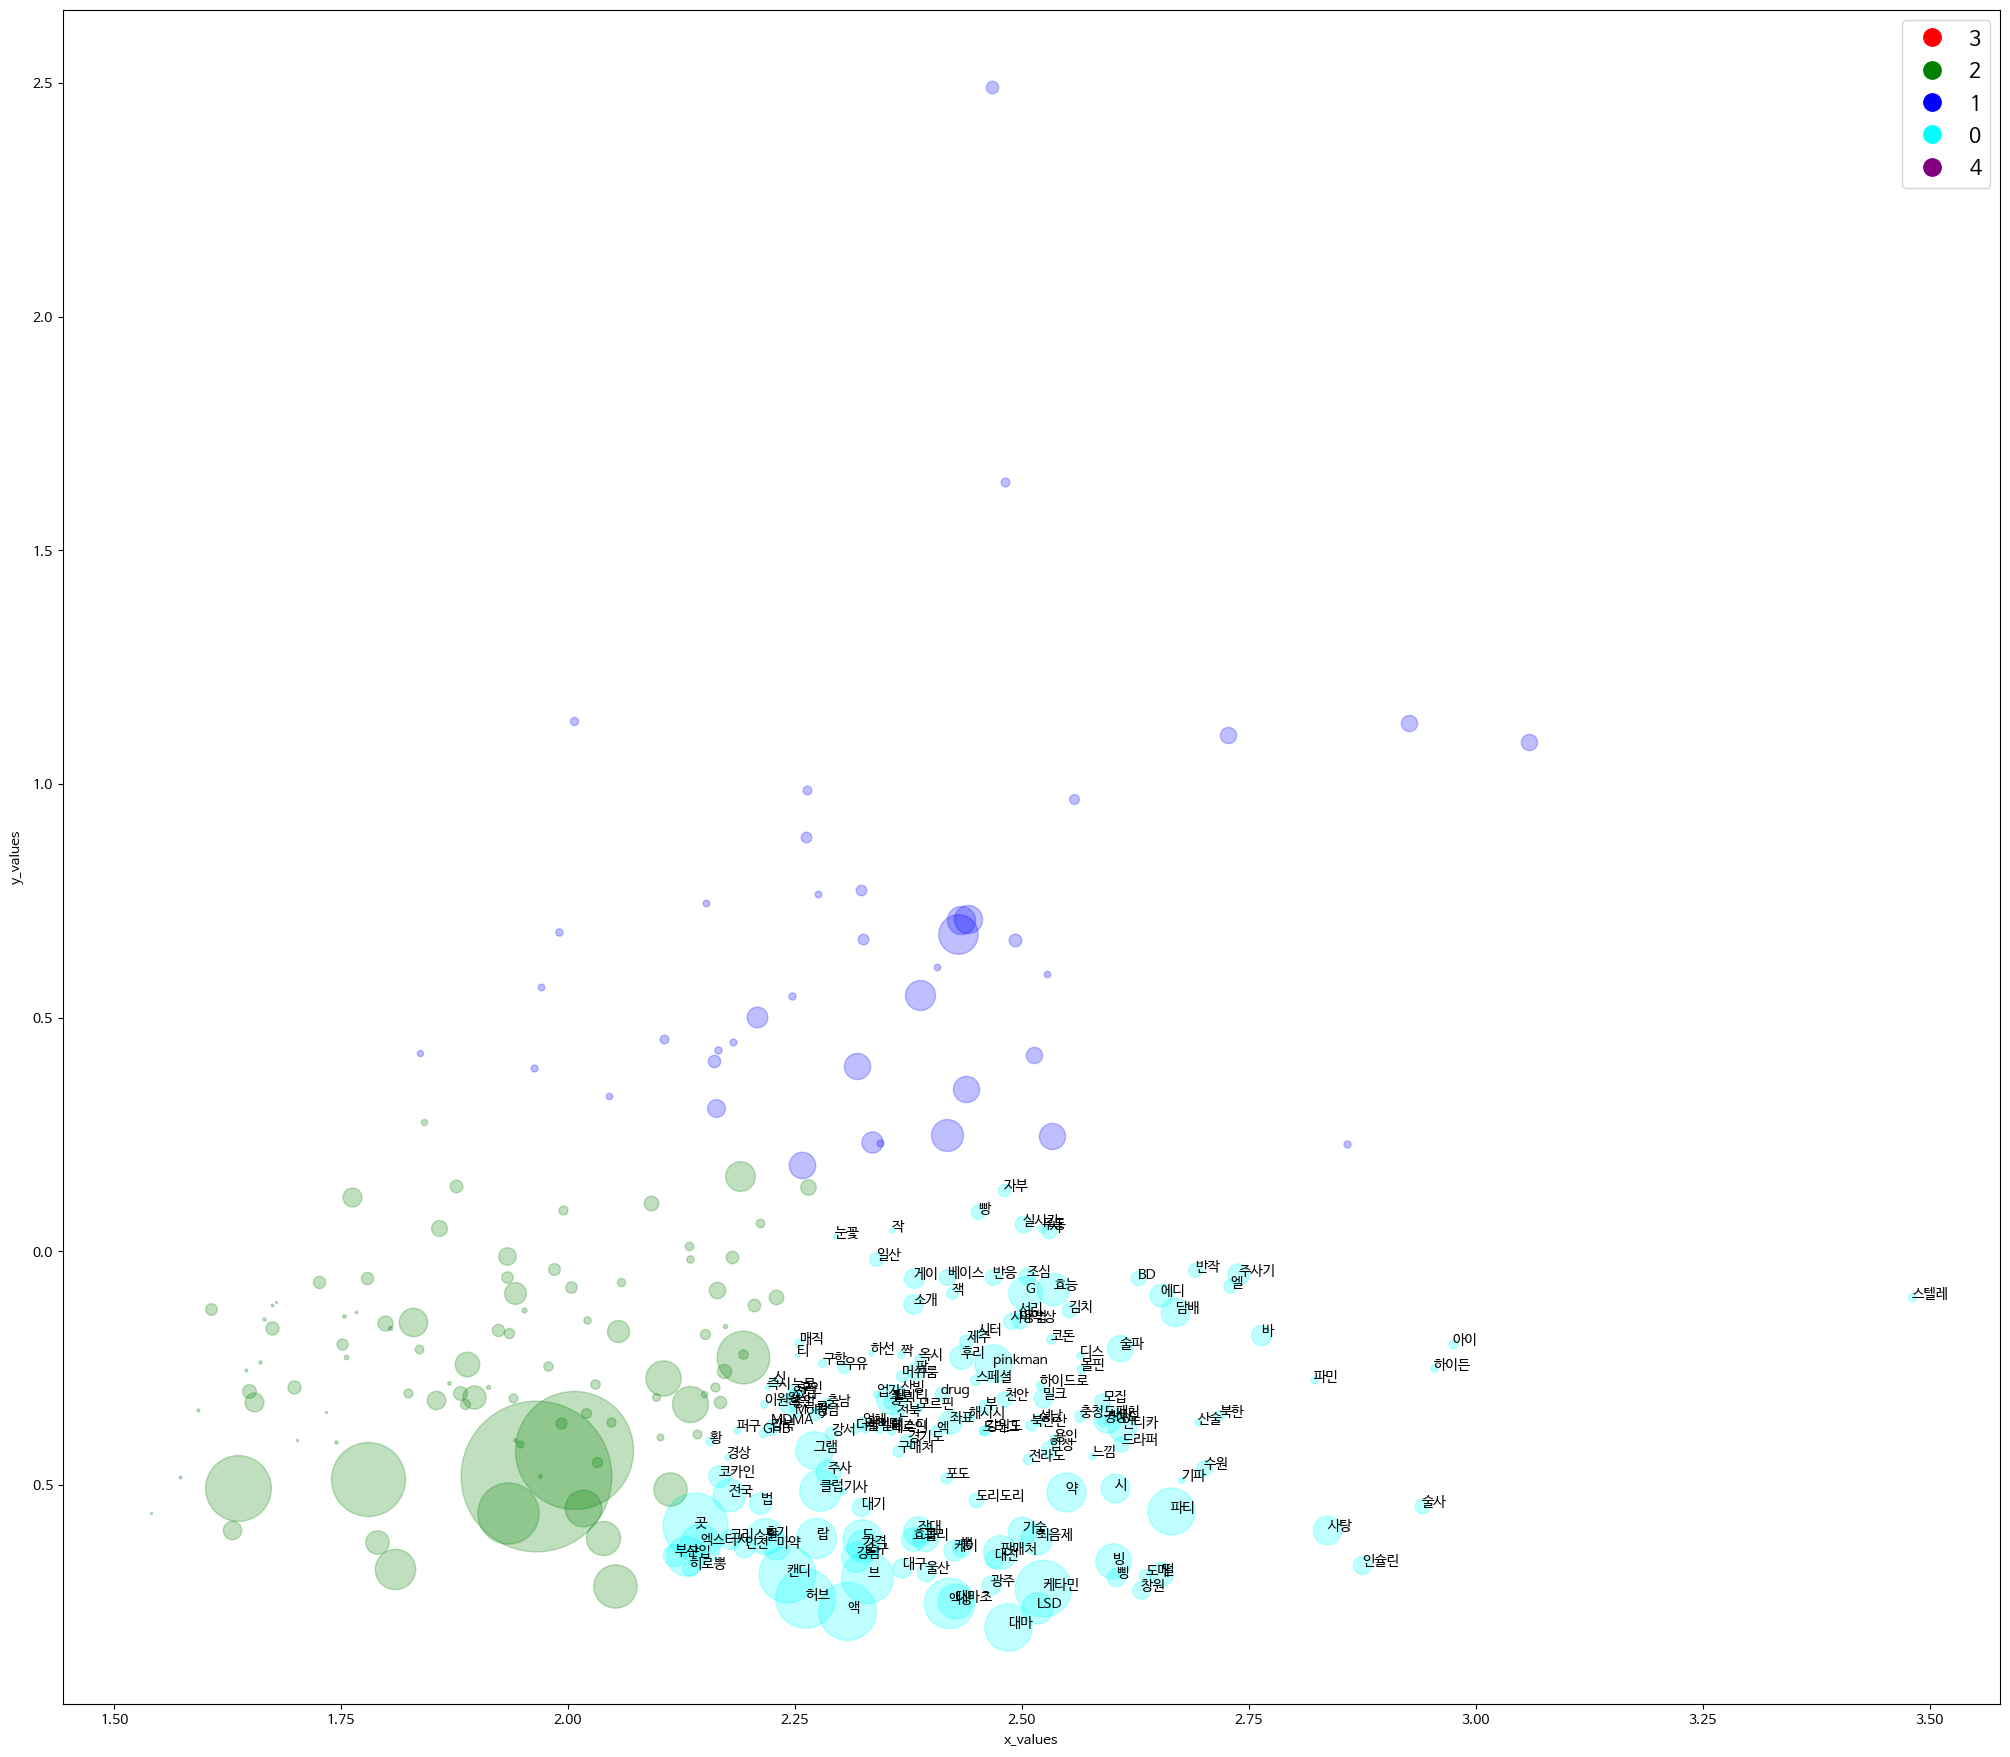

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_drug.labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_drug.iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_drug.x_values[i], PCA_drug.y_values[i], s=PCA_drug.counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_drug.iterrows() if row.labels == PCA_data_complet.labels[0]]
#[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_drug.iterrows()]
plt.show()

### 버전5: 검색 키워드 제외

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


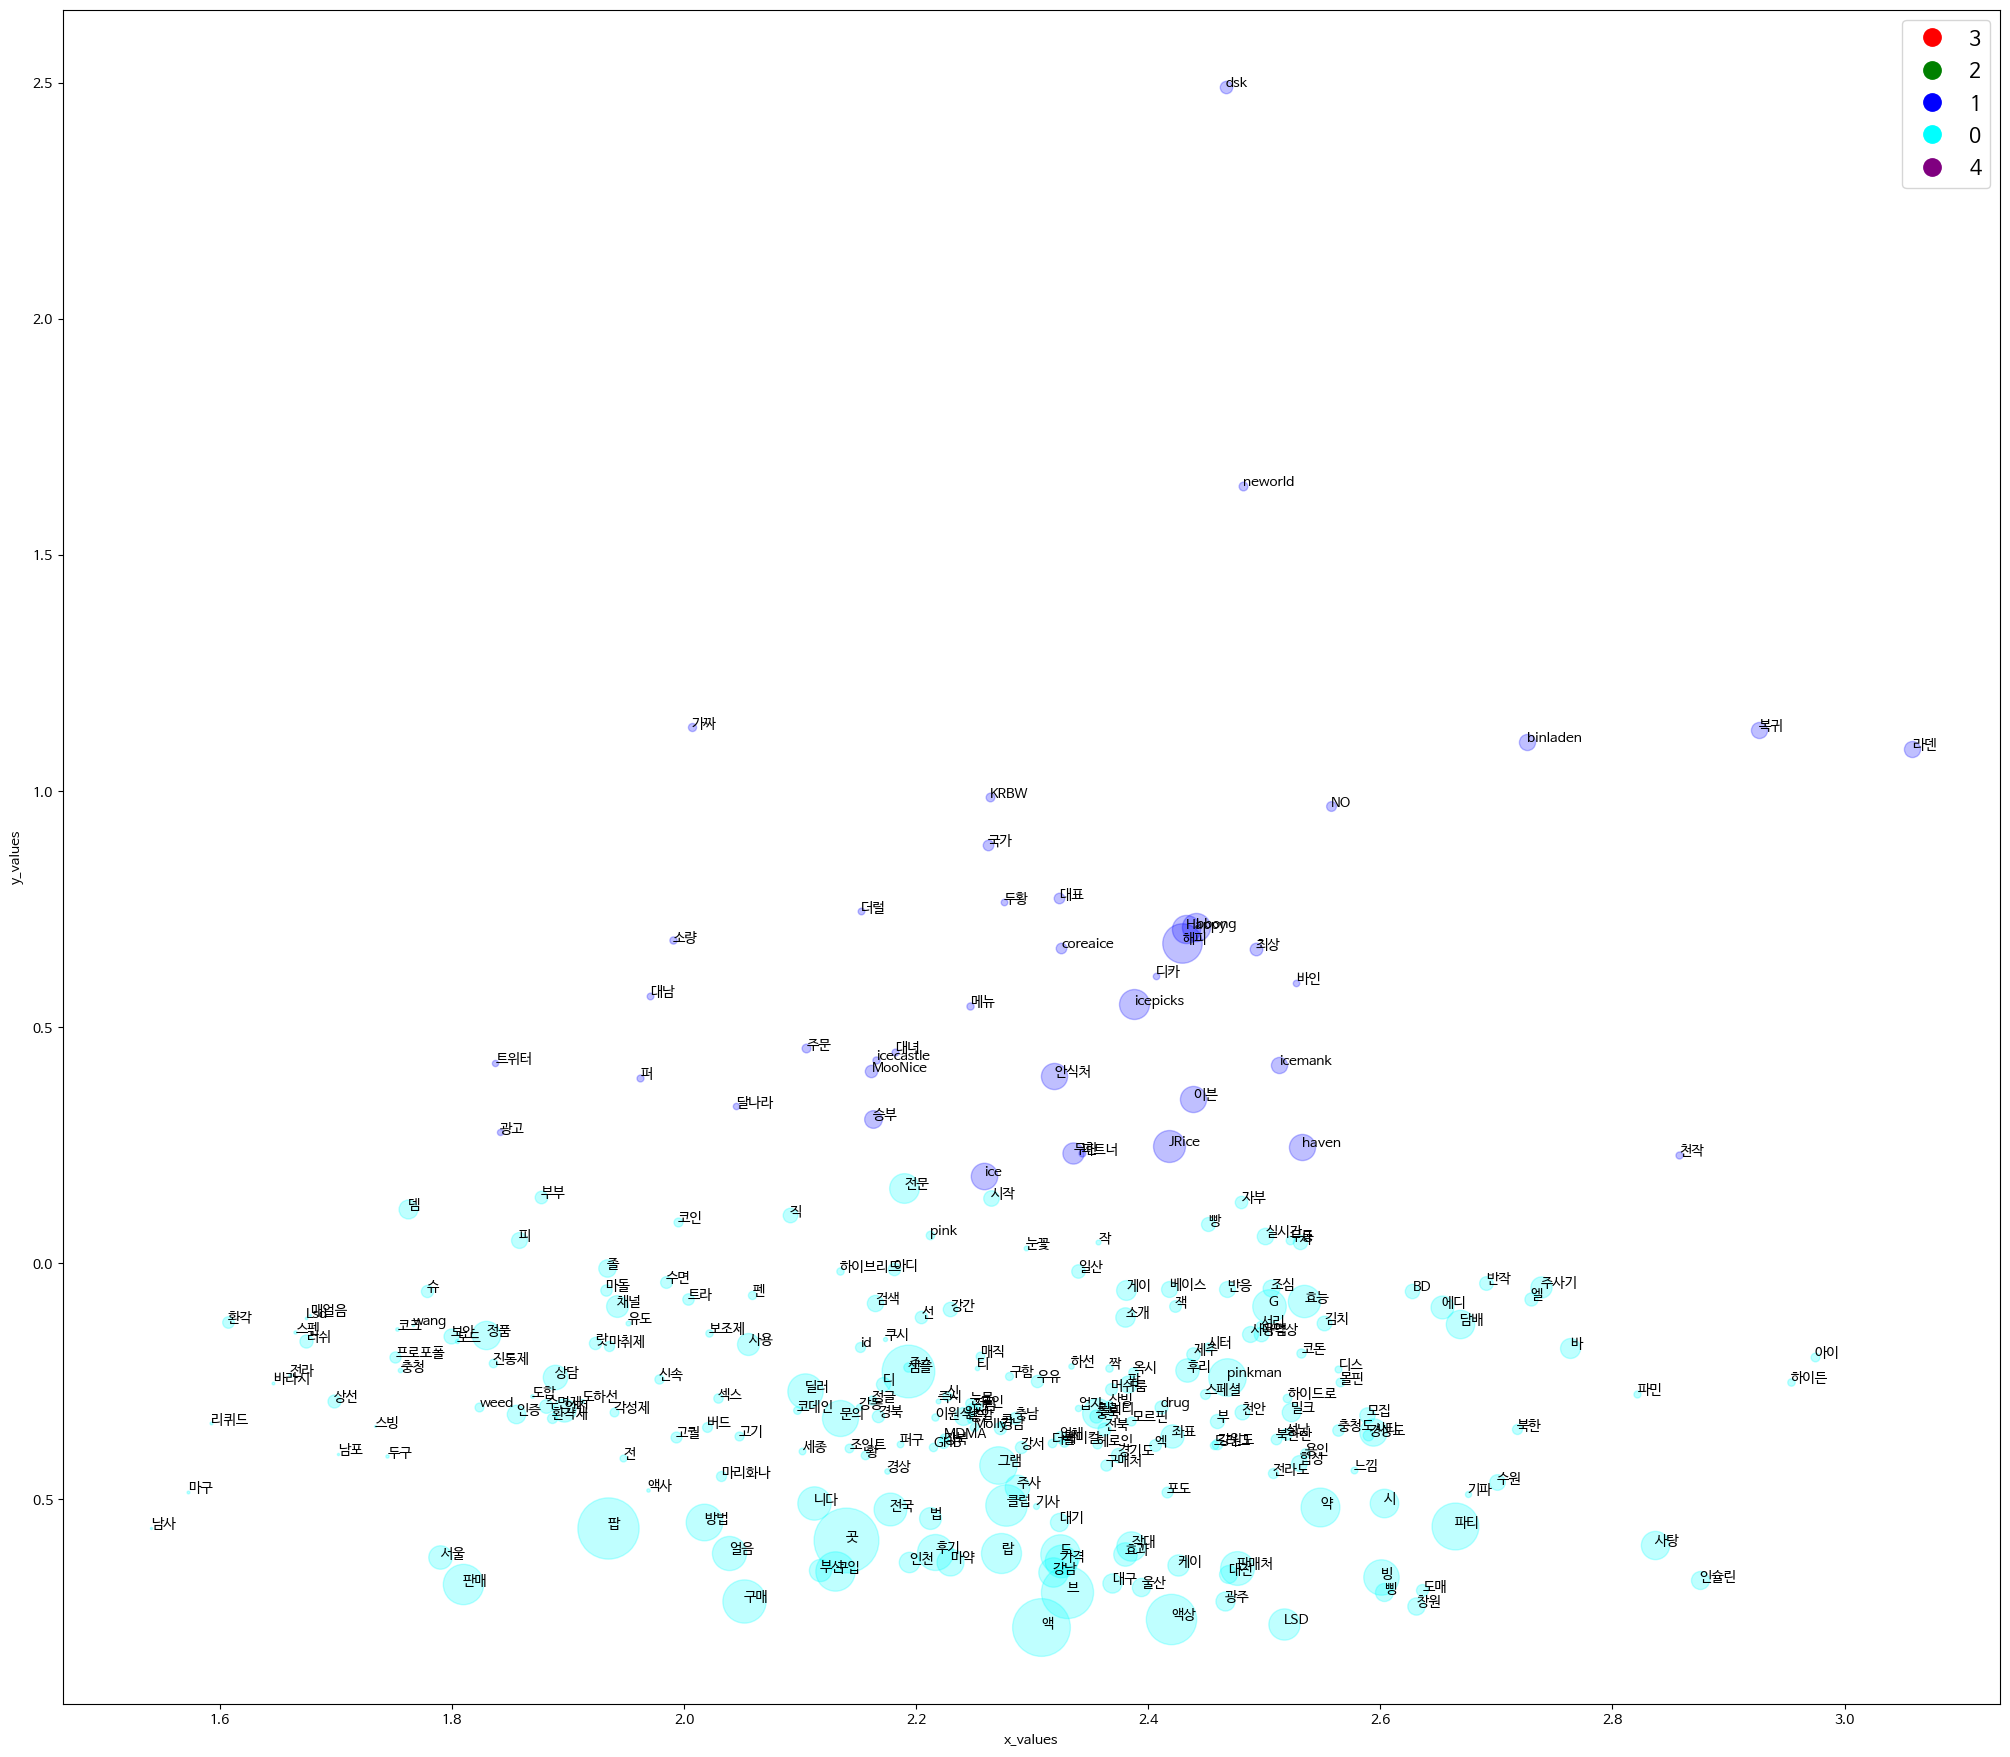

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_drug_removed.labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_drug_removed.iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_drug_removed.x_values[i], PCA_drug_removed.y_values[i], s=PCA_drug_removed.counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

#[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet.iterrows() if row.labels == PCA_data_complet.labels[0]]
[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_drug_removed.iterrows()]
plt.show()

#### 2차 클러스터링 마약 군집에서 3차 클러스터링

In [ ]:
PCA_drug_removed = PCA_drug_removed.reset_index()
PCA_drug_removed = PCA_drug_removed.drop(columns = ['index']) 
PCA_drug2 = PCA_drug_removed[PCA_drug_removed['labels']==PCA_drug_removed.loc[0].labels]

In [ ]:
from sklearn.cluster import KMeans

x = []   # k 가 몇개인지 
y = []   # 응집도가 몇인지 

for k in range(1, 30):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(PCA_drug2.iloc[0:,1:3])
    
    x.append(k)
    y.append(kmeans.inertia_)

In [ ]:
plt.plot(x, y)

In [ ]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(PCA_drug2.iloc[0:,1:3])
PCA_drug2['labels'] = kmeans.predict(PCA_drug2.iloc[0:,1:3])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-110-e5ead1960841>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PCA_drug2['labels'] = kmeans.predict(PCA_drug2.iloc[0:,1:3])


In [ ]:
PCA_drug2

word  x_values  y_values  labels  counts
0    곳    2.139642 -0.586511  0       21791 
2    액    2.307824 -0.769452  2       17301 
4    브    2.329684 -0.695890  2       14104 
5    액상   2.419505 -0.752941  2       13167 
6    파티   2.664420 -0.556611  2       11422 
..   ..        ...       ... ..         ... 
239  하선   2.333276 -0.217656  0       150   
241  작    2.357010  0.045666  1       123   
242  눈꽃   2.294477  0.032368  1       116   
243  즉시   2.218900 -0.290656  0       115   
245  티    2.252403 -0.221628  0       100   

[139 rows x 5 columns]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


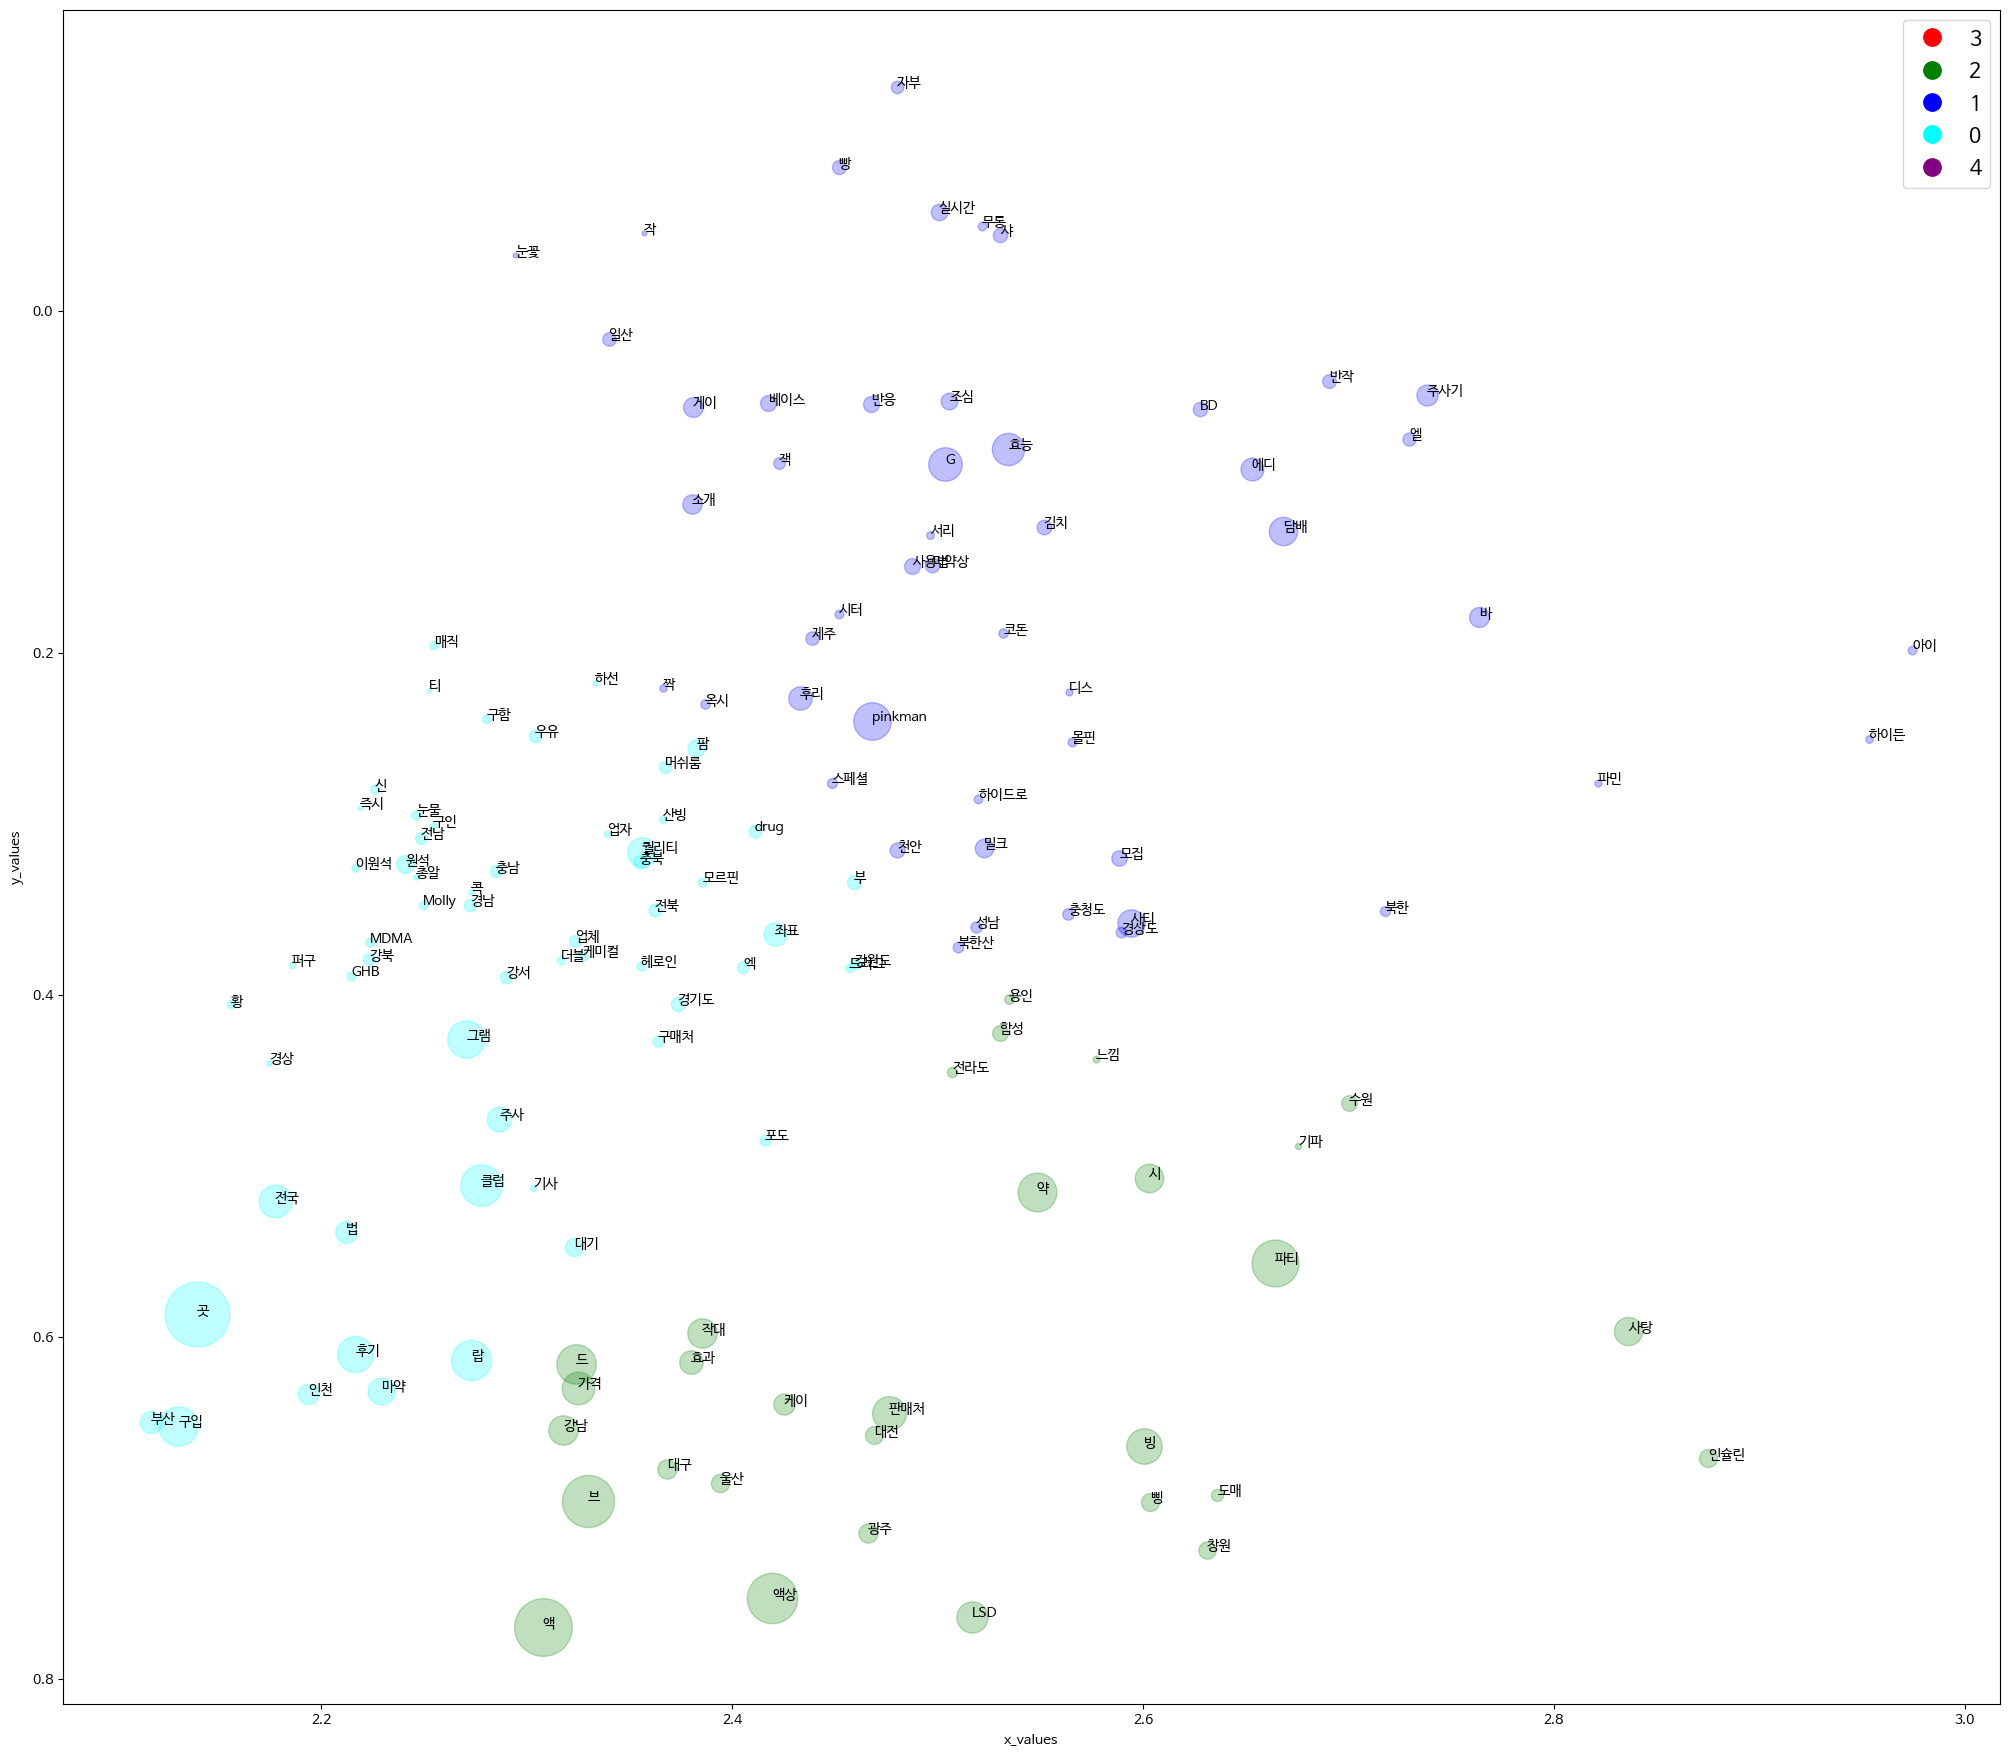

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
from matplotlib.lines import Line2D

figure(num=None, figsize=(25, 22), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel('x_values')
plt.ylabel('y_values')

label = PCA_drug2.labels.unique()

label_colors = {3:'red',
                 2:'green',
                 1:'blue',
                 0:'cyan',
                 4:'purple'}

for i,j in PCA_drug2.iterrows():
    reg_color = label_colors.get(j.labels, 'black')
    plt.scatter(PCA_drug2.x_values[i], PCA_drug2.y_values[i], s=PCA_drug2.counts[i]/10, alpha = 0.25, color=reg_color)


custom = [ Line2D([], [], marker='.', color=i, linestyle='None', markersize=25) for i in label_colors.values()]

plt.legend(custom, label_colors.keys(), fontsize=15)
plt.rc('font', family='NanumBarunGothic') 

#[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_data_complet.iterrows() if row.labels == PCA_data_complet.labels[0]]
[plt.text(x=row['x_values'], y=row['y_values'], s=row['word']) for k,row in PCA_drug2.iterrows()]
plt.show()

# 워드클라우드

## 검색 키워드 제외 X

In [29]:
#딕셔너리로 변환, 2글자 이상인 것만

words = []
counts = []

words_list = list(PCA_drug['word'])
counts_list = list(PCA_drug['counts'])

for i in range(len(words_list)):
    if len(words_list[i]) >= 2:
        words.append(words_list[i])
        counts.append(counts_list[i])

word_count = dict(zip(words, counts))

In [22]:
word_count

{'아이스': 117785,
 '작대기': 72315,
 '텔레': 28410,
 '허브': 18405,
 '캔디': 16746,
 '케타민': 16460,
 '샘플': 14424,
 '액상': 13167,
 '대마': 11651,
 '파티': 11422,
 '구매': 9709,
 '클럽': 8932,
 '엑스터시': 8489,
 '판매': 8459,
 '해피': 8086,
 '구입': 8051,
 'pinkman': 7333,
 '그램': 7313,
 '방법': 6976,
 '문의': 6742,
 '후기': 6737,
 '딜러': 6477,
 '대마초': 6359,
 '얼음': 6053,
 '판매처': 5942,
 '니다': 5789,
 '전국': 5601,
 '가격': 5520,
 '효능': 5438,
 'JRice': 5301,
 'LSD': 5073,
 '최음제': 5072,
 'icepicks': 4666,
 '퀄리티': 4608,
 '전문': 4584,
 '강남': 4495,
 '작대': 4481,
 '담배': 4197,
 '기술': 4186,
 '정품': 4183,
 '인디카': 4183,
 '사탕': 4158,
 'bbong': 4118,
 'Happy': 4118,
 '사티': 3900,
 '마약': 3788,
 'ice': 3632,
 '몰리': 3569,
 '안식처': 3559,
 '이븐': 3554,
 'haven': 3553,
 '술파': 3520,
 '주사': 3160,
 '상담': 3118,
 '효과': 2878,
 '후리': 2863,
 '서울': 2863,
 '좌표': 2822,
 '안전': 2805,
 '에디': 2736,
 '부산': 2564,
 '사용': 2517,
 '채널': 2480,
 '코카인': 2430,
 '케이': 2339,
 '주사기': 2337,
 '무한': 2334,
 '아이스픽': 2218,
 '인천': 2170,
 '게이': 2040,
 '크리스탈': 2018,
 '소개': 1964,
 '대구': 1928

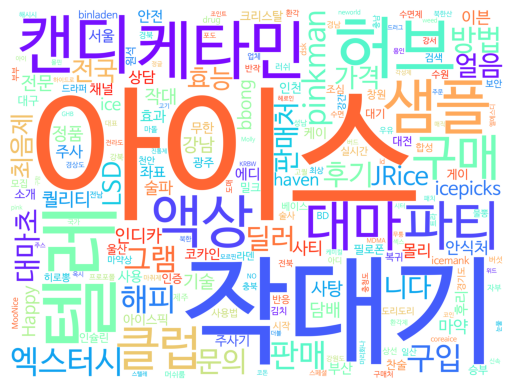

In [30]:
#워드클라우드 생성

from wordcloud import WordCloud

wordcloud = WordCloud(font_path = 'NanumBarunGothic', background_color = 'white', colormap = 'rainbow',
                     width = 4000, height = 3000).generate_from_frequencies(word_count)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 검색 키워드 제외

In [31]:
#딕셔너리로 변환, 2글자 이상인 것만
words_rev = []
counts_rev = []

words_list_rev = list(PCA_drug_removed['word'])
counts_list_rev = list(PCA_drug_removed['counts'])

for i in range(len(words_list_rev)):
    if len(words_list_rev[i]) >= 2:
        words_rev.append(words_list_rev[i])
        counts_rev.append(counts_list_rev[i])

word_count_removed = dict(zip(words_rev, counts_rev))

In [32]:
word_count_removed

{'샘플': 14424,
 '액상': 13167,
 '파티': 11422,
 '구매': 9709,
 '클럽': 8932,
 '판매': 8459,
 '해피': 8086,
 '구입': 8051,
 'pinkman': 7333,
 '그램': 7313,
 '방법': 6976,
 '문의': 6742,
 '후기': 6737,
 '딜러': 6477,
 '얼음': 6053,
 '판매처': 5942,
 '니다': 5789,
 '전국': 5601,
 '가격': 5520,
 '효능': 5438,
 'JRice': 5301,
 'LSD': 5073,
 'icepicks': 4666,
 '퀄리티': 4608,
 '전문': 4584,
 '강남': 4495,
 '작대': 4481,
 '담배': 4197,
 '정품': 4183,
 '사탕': 4158,
 'bbong': 4118,
 'Happy': 4118,
 '사티': 3900,
 '마약': 3788,
 'ice': 3632,
 '안식처': 3559,
 '이븐': 3554,
 'haven': 3553,
 '주사': 3160,
 '상담': 3118,
 '효과': 2878,
 '후리': 2863,
 '서울': 2863,
 '좌표': 2822,
 '안전': 2805,
 '에디': 2736,
 '부산': 2564,
 '사용': 2517,
 '채널': 2480,
 '케이': 2339,
 '주사기': 2337,
 '무한': 2334,
 '인천': 2170,
 '게이': 2040,
 '소개': 1964,
 '대구': 1928,
 '광주': 1901,
 '밀크': 1795,
 '인증': 1776,
 '울산': 1740,
 '대기': 1712,
 '인슐린': 1692,
 '원석': 1679,
 '대전': 1669,
 '승부': 1631,
 '창원': 1566,
 '조심': 1466,
 '실시간': 1419,
 '검색': 1391,
 'icemank': 1366,
 'binladen': 1356,
 '복귀': 1356,
 '라덴': 1356,
 '반응':

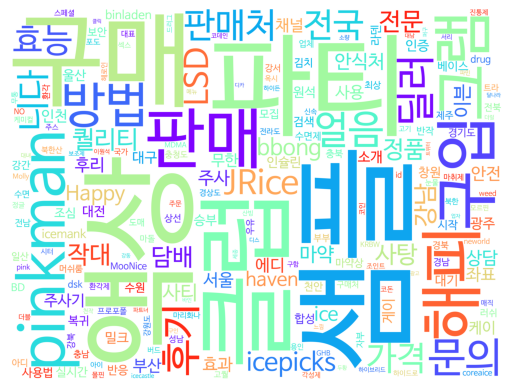

In [33]:
#워드클라우드 생성

from wordcloud import WordCloud

wordcloud_removed = WordCloud(font_path = 'NanumBarunGothic', background_color = 'white', colormap = 'rainbow_r',
                     width = 4000, height = 3000).generate_from_frequencies(word_count_removed)

plt.imshow(wordcloud_removed)
plt.axis('off')
plt.show()